In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import scikitplot.metrics as skplt
import joblib

In [3]:
train_df = pd.read_csv("../Data/eng_train_tfidf_w2v.csv")
test_df = pd.read_csv("../Data/eng_test_tfidf_w2v.csv")
X_train = train_df.drop(columns=["Y"])
Y_train = train_df["Y"]
X_test = test_df.drop(columns=["Y"])
Y_test = test_df["Y"]
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Sub-task B
0,-0.464405,0.085329,0.173662,0.860080,0.162921,-0.741914,0.315726,-1.246204,-0.937708,0.418124,...,-0.912053,0.099934,-0.105449,0.455918,-0.377562,-0.310955,-0.398106,0.410669,0.241518,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
2,-0.398924,0.354351,-1.023667,1.141956,-0.187783,-0.626702,0.544659,-0.073548,-0.048320,0.490205,...,-0.299538,-0.334773,0.159419,-0.183133,0.007446,0.210824,-1.105538,0.216379,0.053901,1
3,0.762408,-0.334276,0.130950,0.725829,0.094326,-0.257330,0.098190,-0.804500,0.341497,-0.263209,...,0.410567,0.434546,-0.284038,-0.232772,-0.507335,0.400088,0.589962,0.354255,-0.205002,1
4,0.161286,-0.124431,-0.671367,0.730329,0.847249,-0.320956,0.256534,-0.360477,0.125937,-0.067365,...,0.047039,0.287160,-0.483786,-0.508252,0.371955,-0.570179,0.065750,-0.065757,-0.693040,1


In [4]:
scaler = MinMaxScaler()
scaler.fit(X_train)
scaler.partial_fit(X_test)
X_train_tf = scaler.transform(X_train)
X_test_tf = scaler.transform(X_test)

In [7]:
def run_the_mn_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'mnb1':
        
        mn_params = {
            'fit_prior': [True],
            'alpha': [0, 0.5, 1]}
        
        M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'mnb2':
        
         mn_params = {
            'fit_prior': [False],
            'alpha': [0, 0.5, 1]}
        
         M = GridSearchCV(MultinomialNB(),
                        mn_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print('There is an error.')
        
    M.fit(X_train_text_df, y_train)
     
    print(f'Train score = {M.score(X_train_text_df, y_train)}')
    print(f'Test score = {M.score(X_test_text_df, y_test)}')
    
    predictions = M.predict(X_test_text_df)
    predictions_train = M.predict(X_train_text_df)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     #skplt.plot_roc_curve(predictions,y_test)
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    2.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    2.9s finished
/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Train score = 0.5710731652154246
Test score = 0.5620052770448549
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'alpha': 0, 'fit_prior': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.48      0.69      0.57      1239
         NAG       0.61      0.53      0.57      1283
         OAG       0.67      0.47      0.55      1268

    accuracy                           0.56      3790
   macro avg       0.59      0.56      0.56      3790
weighted avg       0.59      0.56      0.56      3790



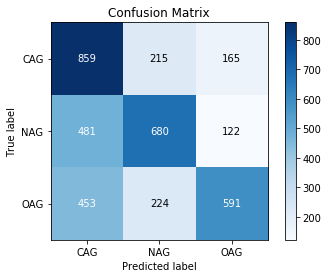

In [8]:
run_the_mn_models("mnb1", X_train_tf, X_test_tf, Y_train, Y_test)

In [9]:
def run_the_lr_models(model, X_train, X_test, Y_tr, Y_te):
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    
    if model == 'lr1':
        
        lr_1_params = {
            'penalty': ['l1'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],
            'random_state': [42],
            'solver': ['liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_1_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'lr2':
        
        lr_2_params = {
            'penalty': ['l2'],
            'C': [1, 1.5, 2, 2.5],
            'class_weight': ['balanced'],
            'warm_start': [True, False],            
            'random_state': [42],
            'solver': ['lbfgs', 'liblinear']}
        
        M = GridSearchCV(LogisticRegression(),
                        lr_2_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)

    else:
        print('There is an error.')
        
    M.fit(X_train_text_df.values, y_train)
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))
    
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   24.4s finished
/home/rachit/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Train score = 0.6425421237136718
Test score = 0.6313984168865435
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1.5, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 42, 'solver': 'lbfgs', 'warm_start': True}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.60      0.56      0.58      1239
         NAG       0.63      0.70      0.66      1283
         OAG       0.67      0.64      0.65      1268

    accuracy                           0.63      3790
   macro avg       0.63      0.63      0.63      3790
weighted avg       0.63      0.63      0.63      3790



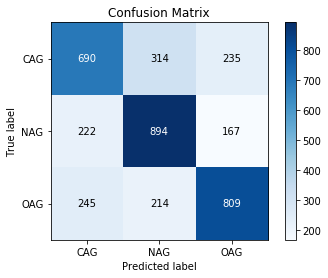

In [10]:
run_the_lr_models("lr2", X_train, X_test, Y_train, Y_test)

In [11]:
def run_the_sv_models(model, X_train, X_test, Y_tr, Y_te):   
    X_train_text_df, X_test_text_df, y_train, y_test = X_train, X_test, Y_tr, Y_te
    
    if model == 'sv1':
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [1e-3, 1e-4],
            'C': [1, 10, 100, 1000] }
        
        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    elif model == 'sv2':
        
        
        sv_params = {
            'kernel': ['rbf'], 
            'gamma': [0.01, 1, 10, 100],
            'C': [1, 10, 100, 1000] }

        M = GridSearchCV(SVC(probability=True),
                        sv_params,
                        cv = 5,
                        verbose = 1,
                        n_jobs = -1)
        
    else:
        print("Invalid Model!")
        
    M.fit(X_train_text_df.values, y_train)
      
    #save in pickle file
    joblib.dump(M, "SVM_TFIDF.pkl")
     
    print(f'Train score = {M.score(X_train_text_df.values, y_train)}')
    print(f'Test score = {M.score(X_test_text_df.values, y_test)}')
    
    predictions = M.predict(X_test_text_df.values)
    predictions_train = M.predict(X_train_text_df.values)
    
    print('--------')
    print(skplt.plot_confusion_matrix(y_test, predictions))
    print(f'Best params = {M.best_params_}')
    print('----F1 Score, Recall, Precision----')
    # print precision, recall, F1-score per each class/tag
    print(classification_report(y_test, predictions))
#     print('----ROC AUC CURVE SCORE----')
#     print("ROC AUC CURVE SCORE FOR TEST: ",roc_auc_score(y_test, predictions))
#     print("ROC AUC CURVE SCORE FOR TRAIN: ",roc_auc_score(y_train, predictions_train))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 17.5min finished


Train score = 0.8234761958611331
Test score = 0.8150395778364116
--------
AxesSubplot(0.125,0.125;0.62x0.755)
Best params = {'C': 1, 'gamma': 10, 'kernel': 'rbf'}
----F1 Score, Recall, Precision----
              precision    recall  f1-score   support

         CAG       0.88      0.75      0.81      1239
         NAG       0.72      0.88      0.79      1283
         OAG       0.88      0.82      0.85      1268

    accuracy                           0.82      3790
   macro avg       0.83      0.81      0.82      3790
weighted avg       0.83      0.82      0.82      3790



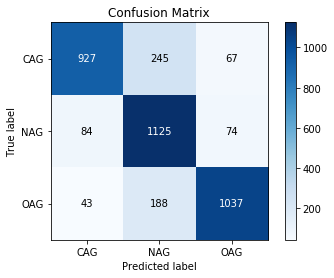

In [12]:
run_the_sv_models("sv2", X_train, X_test, Y_train, Y_test)